In [1]:
%matplotlib inline
import tensorflow as tf
import indl
from pathlib import Path
import sys
import time
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import pickle
from sklearn.decomposition import PCA
from scipy import signal
from scipy import stats
from sklearn.model_selection import train_test_split
from indl.fileio import from_neuropype_h5
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import FactorAnalysis
from itertools import cycle
from filterpy.kalman.UKF import UnscentedKalmanFilter as ukf
from filterpy.kalman import MerweScaledSigmaPoints


import os

if Path.cwd().stem == 'Analysis':
    os.chdir(Path.cwd().parent.parent)

from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc    
    
data_path = Path.cwd() / 'StudyLocationRule'/ 'Data' / 'Preprocessed'
if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


In [2]:
def load_joeyo_reaching(data_path, sess_id, x_chunk='lfps', zscore=False):
    """
    Load data from the joeyo dataset.
    :param data_path: path to joeyo data dir (i.e., parent of 'converted'
    :param sess_id: 'indy_2016' + one of '0921_01', '0927_04', '0927_06', '0930_02', '0930_05' '1005_06' '1006_02'
    :param x_chunk: 'lfps' (default), 'mu_rates', 'su_rates', 'spiketimes', or 'mu_spiketimes'.
    :param zscore: Set to True to z-score data before returning. default: False
    :return: X, Y, X_ax_info, Y_ax_info
    """
    file_path = Path(data_path) / 'converted' / (sess_id + '.h5')
    chunks = from_neuropype_h5(file_path)
    chunk_names = [_[0] for _ in chunks]

    Y_chunk = chunks[chunk_names.index('behav')][1]
    Y_ax_types = [_['type'] for _ in Y_chunk['axes']]
    Y_ax_info = {'channel_names': Y_chunk['axes'][Y_ax_types.index('space')]['names'],
                 'timestamps': Y_chunk['axes'][Y_ax_types.index('time')]['times'],
                 'fs': Y_chunk['axes'][Y_ax_types.index('time')]['nominal_rate']}

    X_chunk = chunks[chunk_names.index(x_chunk)][1]
    X_ax_types = [_['type'] for _ in X_chunk['axes']]
    X_ax_info = {'channel_names': X_chunk['axes'][X_ax_types.index('space')]['names'],
                 'timestamps': X_chunk['axes'][X_ax_types.index('time')]['times'],
                 'fs': X_chunk['axes'][X_ax_types.index('time')]['nominal_rate']}

    if zscore:
        X_chunk['data'] = (X_chunk['data'] - np.mean(X_chunk['data'], axis=1, keepdims=True))\
                          / np.std(X_chunk['data'], axis=1, keepdims=True)
        Y_chunk['data'] = (Y_chunk['data'] - np.mean(Y_chunk['data'], axis=1, keepdims=True)) \
                          / np.std(Y_chunk['data'], axis=1, keepdims=True)

    return X_chunk['data'], Y_chunk['data'], X_ax_info, Y_ax_info

def load_dat_with_vel_accel(datadir, sess_idx):
    BEHAV_CHANS = ['CursorX', 'CursorY']
    sess_names = ['indy_201' + _ for _ in ['60921_01', '60927_04', '60927_06', '60930_02', '60930_05', '61005_06',
                                       '61006_02', '60124_01', '60127_03']]
    X, Y, X_ax_info, Y_ax_info = load_joeyo_reaching(datadir, sess_names[sess_idx], x_chunk='mu_spiketimes')

    # Slice Y to only keep required behaviour data (cursor position)
    b_keep_y_chans = np.in1d(Y_ax_info['channel_names'] , BEHAV_CHANS)
    Y = Y[b_keep_y_chans, :]
    Y_ax_info['channel_names'] = [_ for _ in Y_ax_info['channel_names'] if _ in BEHAV_CHANS]

    # Calculate discrete derivative and double-derivative to get velocity and acceleration.
    vel = np.diff(Y, axis=1)
    vel = np.concatenate((vel[:, 0][:, None], vel), axis=1)  # Assume velocity was constant across the first two samples.
    accel = np.concatenate(([[0], [0]], np.diff(vel, axis=1)), axis=1)  # Assume accel was 0 in the first sample.
    Y = np.concatenate((Y, vel, accel), axis=0)
    Y_ax_info['channel_names'] += ['VelX', 'VelY', 'AccX', 'AccY']
    
    return X, Y, X_ax_info, Y_ax_info

def bin_spike_times(X, X_ax_info, bin_duration=0.256, bin_step_dur=0.004):
    bin_samples = int(np.ceil(bin_duration * X_ax_info['fs']))
    bin_starts_t = np.arange(X_ax_info['timestamps'][0], X_ax_info['timestamps'][-1], bin_step_dur)
    bin_starts_idx = np.searchsorted(X_ax_info['timestamps'], bin_starts_t)
    
    # Only keep bins that do not extend beyond the data limit.
    b_full_bins = bin_starts_idx <= (X.shape[-1] - bin_samples)
    bin_starts_idx = bin_starts_idx[b_full_bins]
    bin_starts_t = bin_starts_t[b_full_bins]
    
    # The next chunk of code counts the number of spikes in each bin.
    # Create array of indices to reslice the raster data
    bin_ix = np.arange(bin_samples)[:, None] + bin_starts_idx[None, :]
    # Create buffer to hold the dense raster data
    _temp = np.zeros(X[0].shape, dtype=bool)
    # Create output variable to hold spike counts per bin
    _X = np.zeros((len(bin_starts_idx), X.shape[0]), dtype=np.int32)
    for chan_ix in range(X.shape[0]):
        _X[:, chan_ix] = np.sum(X[chan_ix].toarray(out=_temp)[0][bin_ix], axis=0)
    _X = _X / bin_duration

    return _X.astype(np.float32), bin_starts_t, bin_samples

def get_binned_rates_with_history(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=3):
    bin_stops_t = bin_starts_t + bin_samples / X_ax_info['fs']
    bin_stops_t = bin_stops_t[(N_TAPS-1):]

    _X_tapped = np.lib.stride_tricks.as_strided(_X, shape=(len(bin_stops_t), N_TAPS, _X.shape[-1]),
                                                strides=(_X.strides[-2], _X.strides[-2], _X.strides[-1]))
    
    b_keep_y = Y_ax_info['timestamps'] > bin_stops_t[0]
    n_extra_y = np.sum(b_keep_y) - len(bin_stops_t)
    if n_extra_y > 0:
        b_keep_y[-n_extra_y] = False
    _Y = Y[:, b_keep_y].T
    
    _X_tapped = _X_tapped[:_Y.shape[0], :, :]
    bin_stops_t = bin_stops_t[:_Y.shape[0]]
    
    return _X_tapped, _Y.astype(np.float32), bin_stops_t

def get_binned_rates(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=1):
    bin_stops_t = bin_starts_t + bin_samples / X_ax_info['fs']

    _X_tapped = np.lib.stride_tricks.as_strided(_X, shape=(len(bin_stops_t), 1, _X.shape[-1]),
                                                strides=(_X.strides[-2], _X.strides[-2], _X.strides[-1]))
    
    b_keep_y = Y_ax_info['timestamps'] > bin_stops_t[0]
    n_extra_y = np.sum(b_keep_y) - len(bin_stops_t)
    if n_extra_y > 0:
        b_keep_y[-n_extra_y] = False
    _Y = Y[:, b_keep_y].T
    
    _X_tapped = _X_tapped[:_Y.shape[0], :, :]
    bin_stops_t = bin_stops_t[:_Y.shape[0]]
    
    return _X_tapped, _Y.astype(np.float32), bin_stops_t


def prepare_for_tensorflow(_X_tapped, _Y, p_train=0.8, batch_size=32, stateful=False):
    if stateful:
        # If using stateful then we keep the sequences in order.
        valid_start = int(np.ceil(_X_tapped.shape[0] * p_train))
        X_train = _X_tapped[:valid_start]
        Y_train = _Y[:valid_start]
        X_valid = _X_tapped[valid_start:]
        Y_valid = _Y[valid_start:]
    else:
        # If not using stateful then we shuffle sequences.
        from sklearn.model_selection import train_test_split
        X_train, X_valid, Y_train, Y_valid = train_test_split(_X_tapped, _Y, train_size=p_train)

    # Get mean and std of training data for z-scoring
    _X_mean = np.nanmean(X_train[:, 0, :], axis=0)[None, None, :]
    _X_std = np.nanstd(X_train[:, 0, :], axis=0)[None, None, :]
    _Y_mean = np.nanmean(Y_train, axis=0, keepdims=True)
    _Y_std = np.nanstd(Y_train, axis=0, keepdims=True)

    # Z-score both training and testing data. For Y, only center it.
    X_train = (X_train - _X_mean) / _X_std
    X_valid = (X_valid - _X_mean) / _X_std
    Y_train = (Y_train - _Y_mean)  # / _Y_std  # Only standardize Y if top layer demands it.
    Y_valid = (Y_valid - _Y_mean)  # / _Y_std  # Only standardize Y if top layer demands it.
    
    # Also transform all of _X_tapped and _Y for plotting.
    _X_tapped = (_X_tapped - _X_mean) / _X_std
    _Y = (_Y - _Y_mean)

    ds_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

    if not stateful:
        ds_train = ds_train.shuffle(int(_X_tapped.shape[0] * P_TRAIN) + 1)
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
    ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=True)
    
    return _X_tapped, _Y, ds_train, ds_valid

In [3]:
class ManualKalmanFilter(object):
    def __init__(self, x, z):
        self.x = x
        self.z = z
        self.m = np.size(self.x, 0)
        self.n = np.size(self.z, 0)
        self.F = np.zeros((self.m, self.m))
        self.H = np.zeros((self.n, self.m))
        self.Q = np.zeros((self.m, self.m))
        self.R = np.zeros((self.n, self.n))
        self.xk_bar = np.zeros(self.m)
        self.pk_bar = np.zeros((self.m, self.m))
        self.P = np.eye(self.m)
        self.model_initialize()

    def model_initialize(self):
        # F = X2.X1^T.(X1.X1^T)^-1
        x1 = self.x[:, :-1]
        x2 = self.x[:, 1:]
        temp1 = np.dot(x2, x1.T)
        temp2 = np.linalg.inv(np.dot(x1, x1.T))
        self.F = np.dot(temp1, temp2)
        # Q = ((X2 - F.X1).(X2 - FX1)^T) / (M-1)
        temp = x2 - np.dot(self.F, x1)
        self.Q = np.dot(temp, temp.T) / (self.m - 1)
        # H = Z.X^T.(X.X^T)^-1
        temp1 = np.dot(self.z, self.x.T)
        temp2 = np.linalg.inv(np.dot(self.x, self.x.T))
        self.H = np.dot(temp1, temp2)
        # R = ((Z - H.X).(Z - H.X)^T) / M
        Z_HX = self.z - np.dot(self.H, self.x)
        temp = np.dot(Z_HX, Z_HX.T)
        self.R = np.divide(temp, self.m)

    def predict(self):
        # I. Priori Step
        x_k_minus_one = self.x[:, -1]  # Initial State
        p_k_minus_one = self.P  # Initial Error Covariance
        self.xk_bar = np.dot(self.F, x_k_minus_one)
        temp = np.dot(self.F, p_k_minus_one)
        self.pk_bar = np.dot(temp, np.transpose(self.F)) + self.Q

    def update(self, z_test):
        # Kk = Pk^-.H^T.(H.Pk^-.H^T + R)^-1
        temp = np.dot(self.pk_bar, np.transpose(self.H))
        temp1 = np.dot(self.H, temp) + self.R
        temp2 = np.linalg.inv(temp1)
        kk = np.dot(temp, temp2)
        # Next State Estimation
        zk = z_test
        temp1 = zk - np.dot(self.H, self.xk_bar)  # z - dot(H, x)
        temp2 = np.dot(kk, temp1)
        xk = self.xk_bar + temp2  # x = x + dot(K, y)
        # Next Error Covariance Estimation
        temp = np.eye(self.m) - np.dot(kk, self.H)  # I_KH = self._I - dot(self.K, H)
        pk = np.dot(temp, self.pk_bar)  # self.P = dot(dot(I_KH, self.P), I_KH.T) + dot(dot(self.K, R), self.K.T)
        # Initializing Next Loop
        xk = np.reshape(xk, (self.m, 1))
        self.x = np.hstack((self.x, xk))
        self.P = pk
        # Updating the model
        zk = np.reshape(zk, (self.n, 1))
        self.z = np.hstack((self.z, zk))
        return xk

In [4]:
SESS_IDX = 0          # Index of recording session we will use. 0:8
BIN_DURATION = 0.250  # Width of window used to bin spikes, in seconds
N_TAPS = 2            # Number of bins of history used in a sequence.
P_TRAIN = 0.8         # Proportion of data used for training.
BATCH_SIZE = 32       # Number of sequences in each training step.
P_DROPOUT = 0.05      # Proportion of units to set to 0 on each step.
N_RNN_UNITS = 64      # Size of RNN output (state)
L2_REG = 0.000017       # Parameter regularization strength.
STATEFUL = False      # Whether or not to keep state between sequences (True is not tested)
EPOCHS = 10 

In [5]:
X, Y, X_ax_info, Y_ax_info = load_dat_with_vel_accel(data_path, SESS_IDX)
_X, bin_starts_t, bin_samples = bin_spike_times(X, X_ax_info, bin_duration=BIN_DURATION, bin_step_dur=(1 / Y_ax_info['fs']))
_X_tapped, _Y, bin_stops_t = get_binned_rates_with_history(_X, Y, X_ax_info, bin_starts_t, bin_samples, n_taps=N_TAPS)
print(_X.shape,_X_tapped.shape, _Y.shape)

(89975, 88) (89974, 2, 88) (89974, 6)


KeyboardInterrupt: 

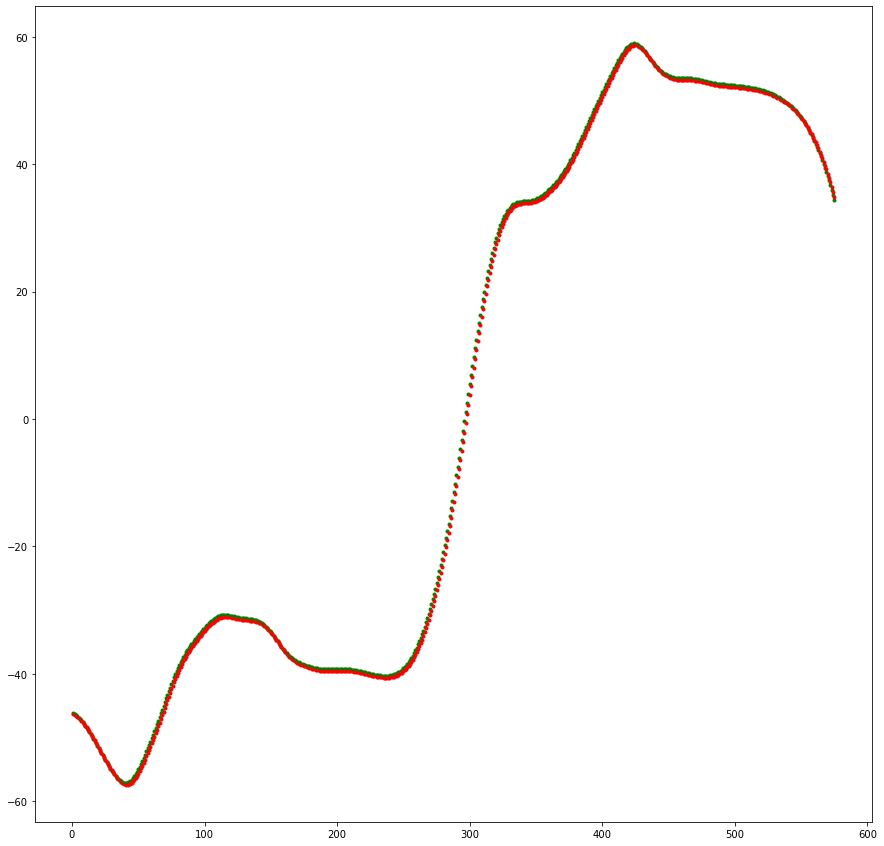

In [7]:
step = 1
x = _Y[step,0]

plt.figure(figsize=(15,15))
while step < 1000:
    plt.plot(step, _Y[step, 0], '.-', color='green', label="True")
    x = x + _Y[step-1,2]
    plt.plot(step, x, '.-', color='red', label="Reversed")
#     plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    step = step + 1

# Offline

In [8]:
import nengo
from nengo.utils.ensemble import sorted_neurons
from nengo.utils.matplotlib import rasterplot

In [9]:
v= _Y[:, 2:4]
def xvelocity(t):
    return v[int(1000*t),0]
def yvelocity(t):
    return v[int(1000*t),1]

model = nengo.Network(label="Velocity Encoder")
with model:
    # Our ensemble consists of N leaky integrate-and-fire neurons,
    # and represents a 2-dimensional signal
    neurons = nengo.Ensemble(100, dimensions=2)

with model:
    # Create input nodes representing the sine and cosine
    xvel = nengo.Node(output=xvelocity)
    yvel = nengo.Node(output=yvelocity)
    
with model:
    # The indices in neurons define which dimension the input will project to
    nengo.Connection(xvel, neurons[0])
    nengo.Connection(yvel, neurons[1])
    
with model:
    xvel_probe = nengo.Probe(xvel, "output")
    yvel_probe = nengo.Probe(yvel, "output")
    output_probe = nengo.Probe(neurons, "decoded_output", synapse=0.01)
    neurons_probe = nengo.Probe(neurons.neurons)

In [10]:
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(89)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [23]:
sim.data[neurons_probe].shape

(89000, 100)

Text(0, 0.5, 'Channel')

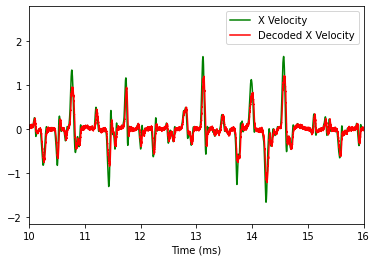

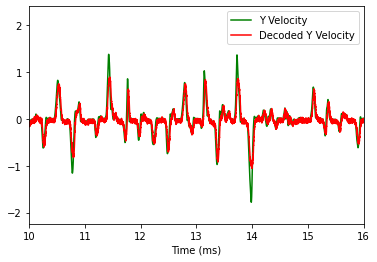

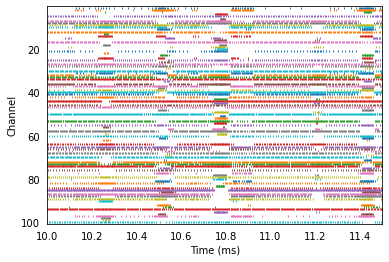

In [11]:
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[xvel_probe], "g", label="X Velocity")
plt.plot(sim.trange(), sim.data[output_probe][:,0], "r", label="Decoded X Velocity")
plt.xlim(10, 16)
plt.legend()
plt.xlabel("Time (ms)")

plt.figure()
plt.plot(sim.trange(), sim.data[yvel_probe], "g", label="Y Velocity")
plt.plot(sim.trange(), sim.data[output_probe][:,1], "r", label="Decoded Y Velocity")
plt.xlim(10, 16)
plt.legend()
plt.xlabel("Time (ms)")
# Plot the spiking output of the ensemble
plt.figure()
rasterplot(sim.trange(), sim.data[neurons_probe])
plt.xlim(10, 11.5)
plt.xlabel("Time (ms)")
plt.ylabel("Channel")

In [12]:
sim_spikes = sim.data[neurons_probe]/np.max(sim.data[neurons_probe])
states = _Y[:sim_spikes.shape[0],:]
print(sim_spikes.shape, states.shape)

(89000, 100) (89000, 6)


In [55]:
np.max(sim_spikes)

1.0

In [13]:
bin_size = 250
sim_rates = np.zeros((sim_spikes.shape[0], sim_spikes.shape[1]))
for t in range(sim_spikes.shape[0]):
    if t < bin_size:
        sim_rates[t,:] = np.sum(sim_spikes[:t], axis=0)
    else:
        sim_rates[t,:] = np.sum(sim_spikes[t-bin_size:t], axis=0)

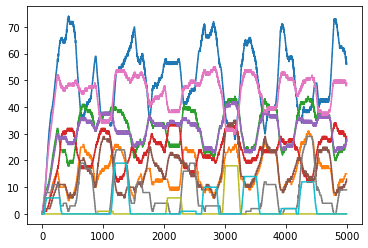

In [57]:
plt.plot(sim_rates[:5000, 0:10])

In [14]:
neural = np.squeeze(sim_rates).T
state = states[:, :4].T

# Seperating training and test samples
training_size = 10000

state_train = state[:, :training_size]
neural_train = neural[:, :training_size]
state_test = state[:, training_size:]
neural_test = neural[:, training_size:]

# Initialize predicted states
kf_predict = np.zeros((4, 6000))

# Instantiating from KF class
mykf = ManualKalmanFilter(x=state_train, z = neural_train)

# Looping through test data
rng = 6000
for i in range(rng):
    mykf.predict()
    neural_in = neural_test[:,i]
    kf_predict[:, i] = np.reshape(mykf.update(neural_in), (mykf.m, ))
    if i%200 == 0:
        print('KF - Step: ' + str(i) + ' out of ' + str(rng))
print('KF Finished')

KF - Step: 0 out of 6000
KF - Step: 200 out of 6000
KF - Step: 400 out of 6000
KF - Step: 600 out of 6000
KF - Step: 800 out of 6000
KF - Step: 1000 out of 6000
KF - Step: 1200 out of 6000
KF - Step: 1400 out of 6000
KF - Step: 1600 out of 6000
KF - Step: 1800 out of 6000
KF - Step: 2000 out of 6000
KF - Step: 2200 out of 6000
KF - Step: 2400 out of 6000
KF - Step: 2600 out of 6000
KF - Step: 2800 out of 6000
KF - Step: 3000 out of 6000
KF - Step: 3200 out of 6000
KF - Step: 3400 out of 6000
KF - Step: 3600 out of 6000
KF - Step: 3800 out of 6000
KF - Step: 4000 out of 6000
KF - Step: 4200 out of 6000
KF - Step: 4400 out of 6000
KF - Step: 4600 out of 6000
KF - Step: 4800 out of 6000
KF - Step: 5000 out of 6000
KF - Step: 5200 out of 6000
KF - Step: 5400 out of 6000
KF - Step: 5600 out of 6000
KF - Step: 5800 out of 6000
KF Finished


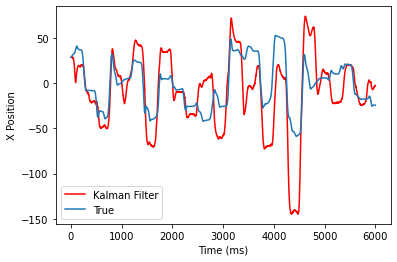

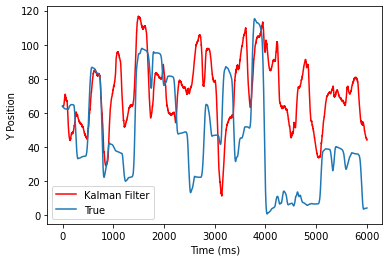

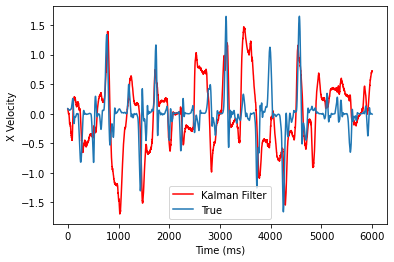

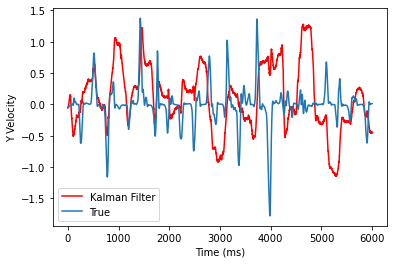

In [15]:
plt.figure()
plt.plot(kf_predict[0,:], color='r', label="Kalman Filter")
plt.plot(state[0,training_size:training_size+rng], label="True")
plt.xlabel("Time (ms)")
plt.ylabel("X Position")
plt.legend()

plt.figure()
plt.plot(kf_predict[1,:], color='r', label="Kalman Filter")
plt.plot(state[1,training_size:training_size+rng], label="True")
plt.xlabel("Time (ms)")
plt.ylabel("Y Position")
plt.legend()

plt.figure()
plt.plot(kf_predict[2,:], color='r', label="Kalman Filter")
plt.plot(state[2,training_size:training_size+rng], label="True")
plt.xlabel("Time (ms)")
plt.ylabel("X Velocity")
plt.legend()

plt.figure()
plt.plot(kf_predict[3,:], color='r', label="Kalman Filter")
plt.plot(state[3,training_size:training_size+rng], label="True")
plt.xlabel("Time (ms)")
plt.ylabel("Y Velocity")
plt.legend()

# Online

In [16]:
import nengo
from nengo.utils.ensemble import sorted_neurons
from nengo.utils.matplotlib import rasterplot

In [17]:
FREQ_RANGE = [10, 50] # The frequncy of neuron's firing
N_NEURON = 100 # Number of channels/neurons
STATE_DIM = 2 # Kinematic input dimension i.e. position + velocity + acceleration

In [18]:
v= _Y[:51, 2:4]
def xvelocity(t):
    return v[int(1000*t),0]
def yvelocity(t):
    return v[int(1000*t),1]

model = nengo.Network(label="Motor")
with model:
    # Our ensemble consists of N leaky integrate-and-fire neurons,
    # and represents a 2-dimensional signal
    neurons = nengo.Ensemble(n_neurons=N_NEURON, dimensions=STATE_DIM,
#                              max_rates=np.random.uniform(FREQ_RANGE[0], FREQ_RANGE[1]),
                             neuron_type=nengo.AdaptiveLIF())

with model:
    # Create input nodes representing the sine and cosine
    xvel = nengo.Node(output=xvelocity)
    yvel = nengo.Node(output=yvelocity)
    
with model:
    # The indices in neurons define which dimension the input will project to
    nengo.Connection(xvel, neurons[0])
    nengo.Connection(yvel, neurons[1])
    
with model:
    xvel_probe = nengo.Probe(xvel, "output")
    yvel_probe = nengo.Probe(yvel, "output")
    output_probe = nengo.Probe(neurons, "decoded_output", synapse=0.01)
    neurons_probe = nengo.Probe(neurons.neurons)

KeyboardInterrupt: 

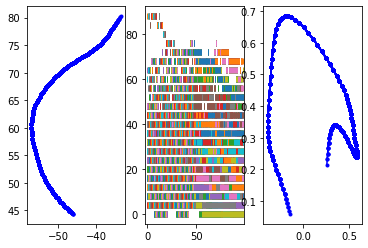

In [19]:
import time
# import matplotlib.pylab as pl
from IPython import display
t = 0
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)


while t < 100:
    ax1.plot(_Y[t:t+50,0], _Y[t:t+50,1],'.-', color='blue')
    ax2.plot(np.arange(t,t+50),_X[t:t+50,:], '|')
    ax3.plot(_Y[t:t+50,2], _Y[t:t+50,3],'.-', color='blue')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    t = t+1
    ax2.set_xlim([t-50, t+50])


In [57]:
_X

array([[32., 44., 16., ..., 40., 48., 40.],
       [32., 40., 16., ..., 40., 48., 40.],
       [32., 40., 16., ..., 40., 52., 36.],
       ...,
       [ 0., 20.,  8., ..., 12.,  0., 12.],
       [ 0., 20.,  8., ..., 12.,  0., 12.],
       [ 0., 20.,  8., ..., 12.,  0., 12.]], dtype=float32)

In [42]:
sim.data[output_probe].shape

(50, 2)

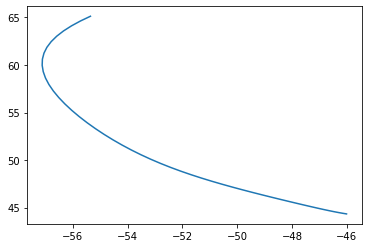

In [16]:
plt.plot(_Y[:50,0], _Y[:50,1])

In [21]:
print(dec_pos)

[[ 0.          0.        ]
 [ 0.          0.        ]
 [-0.00169265 -0.03591764]
 ...
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


KeyboardInterrupt: 

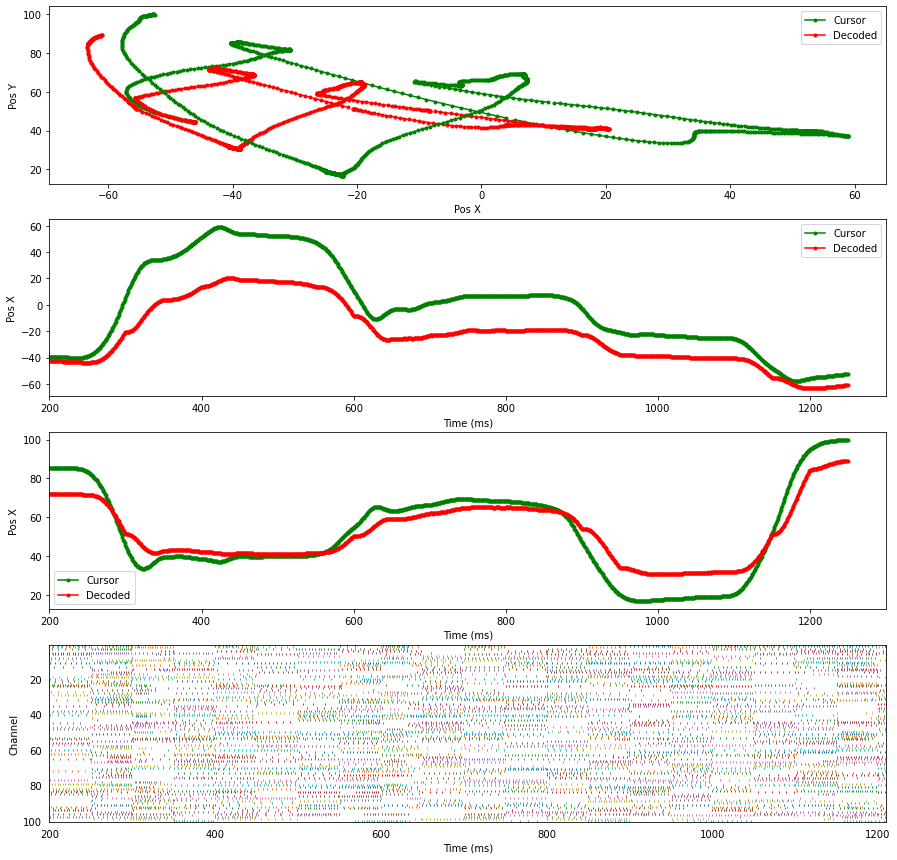

In [20]:
# import matplotlib.pylab as pl


# plot_kwargs = {
#     'colors': ["k"]
# }
BUF_SIZE = 50
dec_pos = np.zeros((_Y.shape[0],2))
dec_pos[0] = _Y[0,:2]
t_step = 0
f, axs = plt.subplots(4,1,figsize=(15,15))
# ax1 = plt.subplot(2, 1, 1)
# ax2 = plt.subplot(2, 1, 2)
while t_step < 5000:
    with nengo.Simulator(model) as sim:
        sim.run(BUF_SIZE/1000, progress_bar=False)
#     xpos = sim.data[xvel_probe] + np.ones(BUF_SIZE)*x0
#     ypos = sim.data[yvel_probe] + np.ones(BUF_SIZE)*y0
#     x0 = xpos[-1]
#     y0 = ypos[-1]
    for i in range(t_step+1,t_step+BUF_SIZE+1):
        dec_pos[i,0] = dec_pos[i-1,0] + sim.data[output_probe][i-t_step-1,0]
        dec_pos[i,1] = dec_pos[i-1,1] + sim.data[output_probe][i-t_step-1,1]
    axs[0].plot(_Y[t_step:t_step+BUF_SIZE,0],_Y[t_step:t_step+BUF_SIZE,1], '.-', color="g", label = "Cursor")
    axs[0].plot(dec_pos[t_step:t_step+BUF_SIZE,0], dec_pos[t_step:t_step+BUF_SIZE,1], '.-', color="r", label="Decoded")
    axs[0].set_xlabel("Pos X")
    axs[0].set_ylabel("Pos Y")
    axs[1].plot(np.arange(t_step, t_step+BUF_SIZE),_Y[t_step:t_step+BUF_SIZE,0], '.-', color="g", label = "Cursor")
    axs[1].plot(np.arange(t_step, t_step+BUF_SIZE), dec_pos[t_step:t_step+BUF_SIZE,0], '.-', color="r", label="Decoded")
    axs[1].set_xlabel("Time (ms)")
    axs[1].set_ylabel("Pos X")
    axs[1].set_xlim([t_step-20*BUF_SIZE, t_step+100])
    axs[2].plot(np.arange(t_step, t_step+BUF_SIZE),_Y[t_step:t_step+BUF_SIZE,1], '.-', color="g", label = "Cursor")
    axs[2].plot(np.arange(t_step, t_step+BUF_SIZE), dec_pos[t_step:t_step+BUF_SIZE,1], '.-', color="r", label="Decoded")
    axs[2].set_xlabel("Time (ms)")
    axs[2].set_ylabel("Pos X")
    axs[2].set_xlim([t_step-20*BUF_SIZE, t_step+100])
#     axs[0].plot(np.arange(t_step, t_step+BUF_SIZE),sim.data[xvel_probe], "g", label = "Cursor")
#     axs[0].plot(np.arange(t_step, t_step+BUF_SIZE),sim.data[output_probe][:,0], "r", label="Decoded")
    rasterplot(np.arange(t_step, t_step+BUF_SIZE), sim.data[neurons_probe], ax=axs[3])
    axs[3].set_xlabel("Time (ms)")
    axs[3].set_ylabel("Channel")
    axs[3].set_xlim([t_step-20*BUF_SIZE, t_step+10])
    if t_step==0:
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    t_step = t_step+BUF_SIZE
#     wait(98)
    v= _Y[t_step:t_step+BUF_SIZE+1, 2:4]
# with nengo.Simulator(model) as sim:
#     # Run it for 1 second
#     sim.run(1, progress_bar=False)
# # Plot the decoded output of the ensemble
# plt.figure()
# plt.plot(sim.trange(), sim.data[xvel_probe], "g", label="X Velocity")
# plt.plot(sim.trange(), sim.data[output_probe][:,0], "r", label="Decoded X Velocity")
# plt.xlim(0, 1)
# plt.legend()
# plt.xlabel("Time (ms)")

# plt.figure()
# plt.plot(sim.trange(), sim.data[yvel_probe], "g", label="Y Velocity")
# plt.plot(sim.trange(), sim.data[output_probe][:,1], "r", label="Decoded Y Velocity")
# plt.xlim(0, 1)
# plt.legend()
# plt.xlabel("Time (ms)")
# # Plot the spiking output of the ensemble
# plt.figure()
# rasterplot(sim.trange(), sim.data[neurons_probe])
# plt.xlim(0, 1)
# plt.xlabel("Time (ms)")
# plt.ylabel("Channel")


# v= _Y[1000:2001, 2:4]
# with nengo.Simulator(model) as sim:
#     # Run it for 1 second
#     sim.run(1, progress_bar=False)
# # Plot the decoded output of the ensemble
# plt.figure()
# plt.plot(sim.trange(), sim.data[xvel_probe], "g", label="X Velocity")
# plt.plot(sim.trange(), sim.data[output_probe][:,0], "r", label="Decoded X Velocity")
# plt.xlim(0, 1)
# plt.legend()
# plt.xlabel("Time (ms)")

# plt.figure()
# plt.plot(sim.trange(), sim.data[yvel_probe], "g", label="Y Velocity")
# plt.plot(sim.trange(), sim.data[output_probe][:,1], "r", label="Decoded Y Velocity")
# plt.xlim(0, 1)
# plt.legend()
# plt.xlabel("Time (ms)")
# # Plot the spiking output of the ensemble
# plt.figure()
# rasterplot(sim.trange(), sim.data[neurons_probe])
# plt.xlim(0, 1)
# plt.xlabel("Time (ms)")
# plt.ylabel("Channel")
f.save('animation.gif', writer='imagemagick', fps=60)

In [8]:
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(89)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

# Scratch

In [21]:

import nengo
from nengo.utils.ensemble import sorted_neurons
from nengo.utils.matplotlib import rasterplot

In [22]:
N = 100 # number of neurons
dn = 10 # window of simulation in ms
dw = dn / 1000 - 0.001

In [23]:
v= _Y[0:0+dn, 2:4]
def xvelocity(t):
    return v[int(1000*t),0]
def yvelocity(t):
    return v[int(1000*t),1]

In [24]:
model = nengo.Network(label="Velocity Encoder")
with model:
    # Our ensemble consists of N leaky integrate-and-fire neurons,
    # and represents a 2-dimensional signal
    neurons = nengo.Ensemble(N, dimensions=2)

In [25]:
with model:
    # Create input nodes representing the sine and cosine
    xvel = nengo.Node(output=xvelocity)
    yvel = nengo.Node(output=yvelocity)

In [26]:
with model:
    # The indices in neurons define which dimension the input will project to
    nengo.Connection(xvel, neurons[0])
    nengo.Connection(yvel, neurons[1])

In [27]:
with model:
    xvel_probe = nengo.Probe(xvel, "output")
    yvel_probe = nengo.Probe(yvel, "output")
    neurons_probe = nengo.Probe(neurons, "decoded_output", synapse=0.01)

In [28]:
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(dw)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

NameError: name 'sin_probe' is not defined

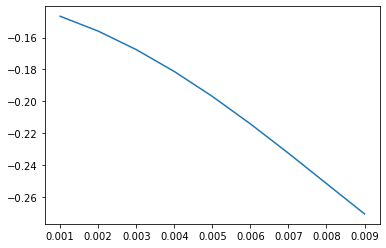

In [29]:
import matplotlib.pylab as pl
from IPython import display

n = 0
tdisp = 0
while n < 10000:
    v = _Y[n:n+dn, 2:4]
    with nengo.Simulator(model) as sim:
        sim.run(dw)
    pl.plot(sim.trange(), sim.data[xvel_probe], label="A output")
    pl.plot(sim.trange(), sim.data[sin_probe], "r", label="Input")
    pl.xlim(tdisp, tdisp+1)
    pl.legend()
    display.clear_output(wait=True)
    display.display(pl.gcf())
    n = n+1
    plt.figure()
    rasterplot(sim.trange(), sim.data[A_spikes])
    plt.xlim(0, 1)
    if n % 1000 == 0:
        tdisp = tdisp + 1

In [30]:
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[A_probe], label="A output")
plt.plot(sim.trange(), sim.data[sin_probe], "r", label="Input")
plt.xlim(0, 1)
plt.legend()

# Plot the spiking output of the ensemble
plt.figure()
rasterplot(sim.trange(), sim.data[A_spikes])
plt.xlim(0, 1)

NameError: name 'A_probe' is not defined

<Figure size 432x288 with 0 Axes>

In [13]:
sim.data[A_spikes].shape

(1000, 100)

In [ ]:
# For interest's sake, you can also sort by encoder
indices = sorted_neurons(A, sim, iterations=250)
plt.figure()
rasterplot(sim.trange(), sim.data[A_spikes][:, indices])
plt.xlim(0, 1)